In [2]:
# General
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pytz
import seaborn as sns
from pandas.api.types import CategoricalDtype
import pickle

# Modelling
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.utils import to_categorical 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# Geolocation libraries
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from global_land_mask import globe

## Info

Resampling is a common method to deal with imbalanced datasets, in order to determine if this is a valid method to deal with the unbalanced species metadata, this notebook will utilize over-sampling and reproduce the Felid Genus and species models, such that direct comparison can be drawn

### Create Dataset

In [7]:
file_path = '../data/processed/'

In [8]:
def aggregate_data(observation_file: str, meta_file: str) -> pd.DataFrame:
    obs_df = pd.read_csv(file_path + observation_file, index_col=0)
    meta_df = pd.read_csv(file_path + meta_file, index_col=0)

    obs_df = obs_df.drop(columns=['observed_on', 'local_time_observed_at', 'positional_accuracy'])
    meta_df = meta_df.drop(columns=['lat', 'long', 'time'])

    df = pd.merge(obs_df, meta_df, how='inner', left_index=True, right_index=True)
    return df

In [9]:
df = aggregate_data('felids_final.csv', 'felids_meta.csv')

### Fit k_means

In [10]:
location_df = df[['latitude', 'longitude']]
location_matrix = location_df.to_numpy()

In [11]:
k_means = KMeans(n_clusters=60, n_init=10)
k_means.fit(location_matrix)
clusters = k_means.cluster_centers_

### Genus Models Upsampled

#### Decision Tree

In [31]:
dt_genus_training_accuracy_oversampled = pd.read_csv('oversample_data_cache/felid_genus_dt_training_accuracy.csv')

In [32]:
dt_genus_training_accuracy = pd.read_csv('felid_data_cache/felid_genus_dt_training_accuracy.csv')

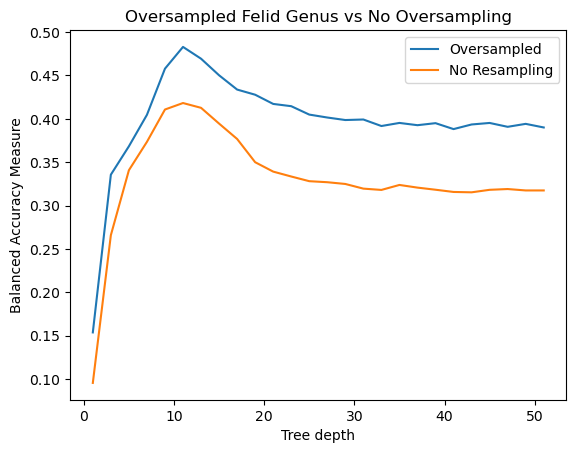

In [33]:
plt.plot(dt_genus_training_accuracy_oversampled['depth'], 
         dt_genus_training_accuracy_oversampled['mean_scores'], label='Oversampled')
plt.plot(dt_genus_training_accuracy['depth'], 
         dt_genus_training_accuracy['mean_scores'], label='No Resampling')

plt.title('Oversampled Felid Genus vs No Oversampling')
plt.xlabel('Tree depth')
plt.ylabel('Balanced Accuracy Measure')
plt.legend()
plt.show()

In [34]:
def prep_dt_validationSet(df:pd.DataFrame, taxon_target:str):
    taxon_y = df[taxon_target]
    
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
    
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                             'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                             'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])

    return X, y

In [35]:
dt_felid_genus_model = pickle.load(open('oversample_data_cache/felid_genus_dt_model.sav', 'rb'))

In [36]:
dt_genus_df_val = pd.read_csv('oversample_data_cache/felid_genus_dt_validation.csv', index_col=0)
X_val, y_val = prep_dt_validationSet(dt_genus_df_val, 'taxon_genus_name')
y_pred = dt_felid_genus_model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

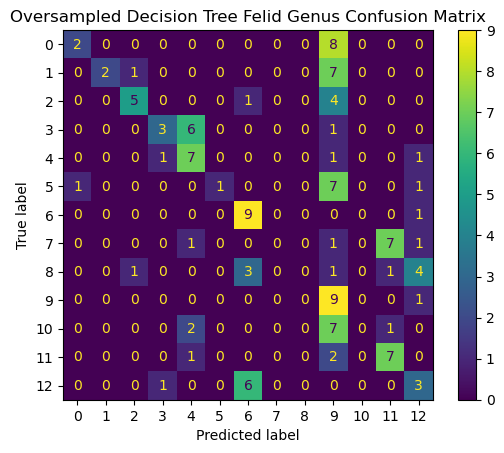

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Oversampled Decision Tree Felid Genus Confusion Matrix')
plt.show()

#### Neural Network

The Genus Neural Network is unweighted. An unknown occurance happens when weighting the classes, such that the neural network's accuracy drops to below 1%.

In [38]:
nn_genus_training_accuracy = pd.read_csv('oversample_data_cache/felid_genus_nn_training_accuracy.csv')

In [39]:
nn_genus_training_accuracy = nn_genus_training_accuracy.T

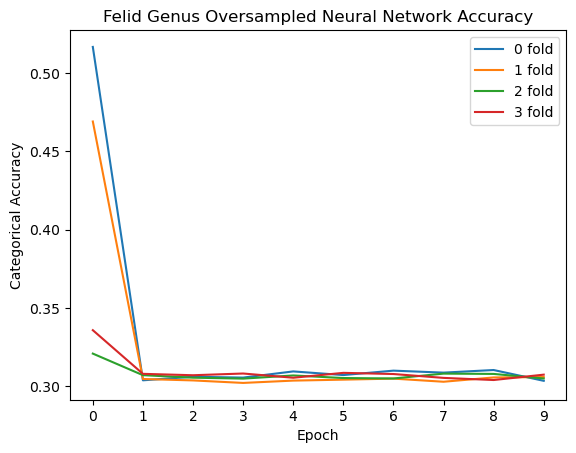

In [40]:
for i in range(nn_genus_training_accuracy.shape[1]):
    plt.plot(nn_genus_training_accuracy[i], label=(str(i) + ' fold'))

    
plt.title('Felid Genus Oversampled Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

Based on the above training accuracies, the use of over-sampling within the meta-data neural network inhibits the learning of the model, actually creating a decreasing learning pattern. 

This model is comparatively worse off that in the `felid_taxonomy_analysis.ipynb` hence neural network models will not be further explored at the species level. 

### Species

#### Lynx

##### Decision Tree

In [41]:
dt_lynx_species_training_accuracy = pd.read_csv('felid_data_cache/lynx_species_dt_training_accuracy.csv')
dt_lynx_species_oversampled_training_accuracy = pd.read_csv('oversample_data_cache/lynx_species_dt_training_accuracy.csv')

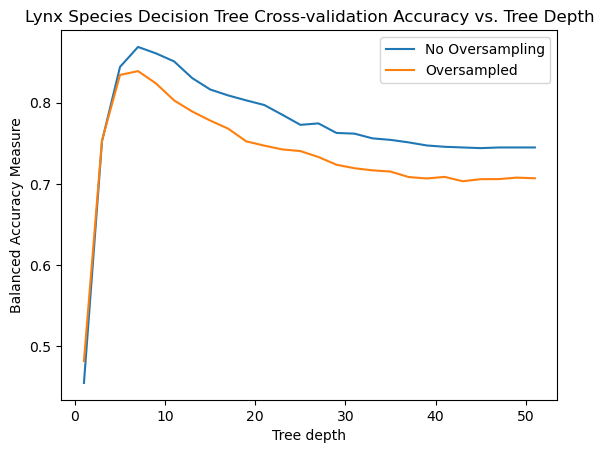

In [43]:
plt.plot(dt_lynx_species_training_accuracy['depth'], 
         dt_lynx_species_training_accuracy['mean_scores'], label='No Oversampling')
plt.plot(dt_lynx_species_oversampled_training_accuracy['depth'], 
         dt_lynx_species_oversampled_training_accuracy['mean_scores'], label='Oversampled')

plt.title('Lynx Species Decision Tree Cross-validation Accuracy vs. Tree Depth')
plt.xlabel('Tree depth')
plt.ylabel('Balanced Accuracy Measure')
plt.legend()
plt.show()

#### Neural Network

In [52]:
nn_lynx_oversampled_species_training_accuracy = pd.read_csv('oversample_data_cache/lynx_species_nn_training_accuracy.csv')
nn_lynx_oversampled_species_training_accuracy = nn_lynx_oversampled_species_training_accuracy.T

In [53]:
nn_lynx_species_training_accuracy = pd.read_csv('felid_data_cache/lynx_species_nn_training_accuracy.csv')
nn_lynx_species_training_accuracy = nn_lynx_species_training_accuracy.T

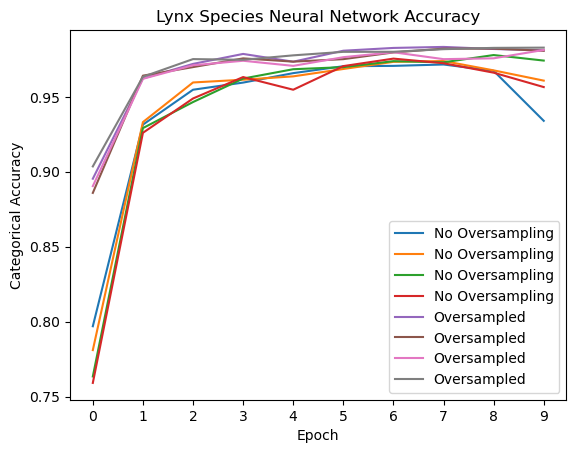

In [54]:
for i in range(nn_lynx_species_training_accuracy.shape[1]):
    plt.plot(nn_lynx_species_training_accuracy[i], label='No Oversampling')
    
for i in range(nn_lynx_oversampled_species_training_accuracy.shape[1]):
    plt.plot(nn_lynx_oversampled_species_training_accuracy[i], label='Oversampled')

    
plt.title('Lynx Species Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

Within the Lynx Genus, there exists significant imbalanced between Lynx Rufus and other Species, which would allow the oversampling to improve the models performance

In [56]:
def prep_nn_validationSet(df:pd.DataFrame, taxon_target:str):
    taxon_y = df[taxon_target]
    
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
    
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                             'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                             'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])
    # Encode labels
    classes = y.nunique()
    lb = LabelBinarizer()
    lb.fit(y)
    y = lb.transform(y)
    
    
    # Normalize numerical columns in the dataset
    norm_columns = ['apparent_temperature', 'apparent_temperature_max', 'apparent_temperature_min',
                    'cloudcover', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'dewpoint_2m',
                    'diffuse_radiation', 'direct_radiation', 'elevation', 'et0_fao_evapotranspiration_daily',
                    'et0_fao_evapotranspiration_hourly', 'precipitation', 'precipitation_hours',
                    'precipitation_sum', 'rain', 'rain_sum', 'relativehumidity_2m', 'shortwave_radiation',
                    'shortwave_radiation_sum', 'snowfall', 'snowfall_sum', 'soil_moisture_0_to_7cm',
                    'soil_moisture_28_to_100cm', 'soil_moisture_7_to_28cm', 'soil_temperature_0_to_7cm',
                    'soil_temperature_28_to_100cm', 'soil_temperature_7_to_28cm', 'surface_pressure',
                    'temperature_2m', 'temperature_2m_max', 'temperature_2m_min', 'vapor_pressure_deficit',
                    'winddirection_100m', 'winddirection_10m', 'winddirection_10m_dominant',
                    'windgusts_10m', 'windgusts_10m_max', 'windspeed_100m', 'windspeed_10m',
                    'windspeed_10m_max']

    X[norm_columns] = StandardScaler().fit_transform(X[norm_columns])
    return X, y, lb

In [72]:
nn_lynx_species_model = keras.models.load_model('oversample_data_cache/lynx_species_nn_model')

In [73]:
nn_lynx_species_df_val = pd.read_csv('oversample_data_cache/lynx_species_nn_validation.csv', index_col=0)

In [74]:
X_val, y_val, lb = prep_nn_validationSet(nn_lynx_species_df_val, 'taxon_species_name')

In [75]:
y_pred = np.argmax(nn_lynx_species_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

1/1 [==============================] - 0s 27ms/step


In [76]:
cm = confusion_matrix(y_true, y_pred)

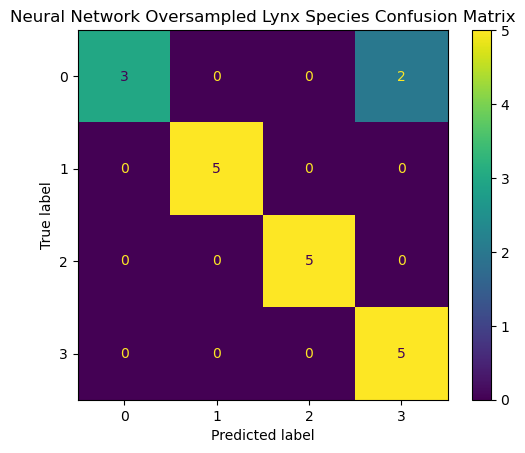

In [78]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Neural Network Oversampled Lynx Species Confusion Matrix')
plt.show()

## Summary

Oversampling aids in both Decision Tree and Neural Network models at lower taxonomic levels (Species, and assumed sub-species). 

However oversampling severly inhibits the learning process of neural networks at the Genus level, and as such should not be utilized at this taxonomic level. 

However, the use of over-sampling improves the performance metrics of both Decision Trees and the Neural Network at the Spcies level, by at least 3%-5%.